# Pêndulo Triplo Caótico

O pêndulo consiste em um corpo acoplado à um fio de "l" comprimento. Este sistema mecânico obedece a atração gravitacional, pois o corpo e fio estão presos abaixo de uma superfície horizontal e, de acordo com o ângulo entre o eixo y e o fio, produz o movimento comum do pêndulo.   

Neste estudo, iremos ilustrar mais de um sistema mecânico do pêndulo, todos relacionados de alguma maneira. Se um pêndulo comum já possui um angulo com o eixo y, um comprimento "l" do fio e produz um movimento circular limitado, o pêndulo triplo se torna mais complexo por depender de mais fatores para ilustrar a trajetória. E, como estte projeto irá trabalhar com um movimento caótico, é necessário um estudo aprofundado sobre as Equações Diferenciais de Lagrange:

Entretanto, este projeto não busca demonstrar cálculos, apenas ilustrar o movimento caótico de "n" pêndulos triplos, como no vídeo a seguir:

In [10]:
%%HTML
<video loop=1 autoplay width="420" height="360"  controls>
  <source src="C:\Users\Guilherme\Documents\Faculdade\Física\Projeto\Segundo Projeto - Caótico\vcaos.mp4" type="video/mp4">
</video>

A animação acima baseia-se na Teoria do Caos, a qual diz que uma pequena mudança no ínicio nas condições do sistema podem trazer resultados totalmentes imprevisíveis, ou seja, caóticos. No caso do sistema dos pêndulos triplos, a condição inicial que foi alterada seria a /* a distância em x entre cada pêndulo */, sendo tão pequena que não é possível identificar que existe mais de um pêndulo triplo preso a superfície.

Para chegar a este resultado, vamos estudar o algoritmo usado para ilustrar o sistema caótico. Os créditos para a construção do código vão para Jake VanderPlas da Universidade de Washington.

# O CÓDIGO

A função a seguir definirá símbolos e valores numéricos e resolverá equações de movimento para um sistema de "n" pêndulos pelo Método de Kane, utilizando a biblioteca Sympy. Esta biblioteca auxilia no desenvolvimento de cálculos ciêntificos mais triviais, como no caso deste método que está relacionado com as equações diferenciais de Lagrange:

In [11]:
"""PÊNDULO TRIPLO CAÓTICO"""

"""PRIMEIRA PARTE: CÁLCULO DAS EQUAÇÕES DO MOVIMENTO DE "N" PÊNDULOS"""


#Bibliotecas
import matplotlib.pyplot as plt
import numpy as np

from sympy import symbols
from sympy.physics import mechanics

from sympy import Dummy, lambdify
from scipy.integrate import odeint


def integrate_pendulum(n, times,
                       initial_positions=135,
                       initial_velocities=0,
                       lengths=None, masses=1):
    #A função acima é chamada como integrate_pendulum, na qual possui os parâmetros que estão entre parenteses
    #Esta função serve como referência para o restante do algoritmo, tornando o código menos complexo.
    
    """Integrando um Pêndulo Multiplo com 'n' seções"""

    #-------------------------------------------------
    # Passo 1: Construir o modelo do pêndulo
    
    #símbolos de posição angular e velocidade para cada massa
    q = mechanics.dynamicsymbols('q:{0}'.format(n)) #Símbolos que serão inicializados como uma função de uma variável
    u = mechanics.dynamicsymbols('u:{0}'.format(n))

    # massa e comprimento
    m = symbols('m:{0}'.format(n))
    l = symbols('l:{0}'.format(n))

    # símbolos da gravidade e tempo
    g, t = symbols('g,t')
    
    #--------------------------------------------------
    # Passo 2: Construir um modelo usando O Método de Kane

    # Criando o ponto de origem em um frame de referência
    A = mechanics.ReferenceFrame('A')
    P = mechanics.Point('P')
    P.set_vel(A, 0)

    #Lista para armazenar partículas, forças e ODEs Cinéticas (ordinary differential equations)...
    #... Para cada cadeia pêndulo na cadeia
    particles = []
    forces = []
    kinetic_odes = []

    for i in range(n): 
        # Create a reference frame following the i^th mass QUE?
        Ai = A.orientnew('A' + str(i), 'Axis', [q[i], A.z])
        Ai.set_ang_vel(A, u[i] * A.z)

        #Criando um ponto neste frame de referência
        Pi = P.locatenew('P' + str(i), l[i] * Ai.x)
        Pi.v2pt_theory(P, A, Ai)

        #Criando uma nova partícula de massa m[i] neste ponto
        Pai = mechanics.Particle('Pa' + str(i), Pi, m[i])
        particles.append(Pai)

        # Set forces & compute kinematic ODE
        # Inserindo as forças e o cálculo das ODEs Cinéticas
        forces.append((Pi, m[i] * g * A.x))
        kinetic_odes.append(q[i].diff(t) - u[i])

        P = Pi

    #Gerando as equação para o movimento
    KM = mechanics.KanesMethod(A, q_ind=q, u_ind=u,
                               kd_eqs=kinetic_odes)
    fr, fr_star = KM.kanes_equations(particles, forces) #INVERTI OS VALORES ENTRE PARENTESES POR CONTA DE UM ERRO
    
    #-----------------------------------------------------
    
    # Passo 3: Atribuição numérica para equações e integradas

    # posições iniciais (em graus) e velocidades 
    y0 = np.deg2rad(np.concatenate([np.broadcast_to(initial_positions, n),
                                    np.broadcast_to(initial_velocities, n)]))
        
    # comprimentos e massas
    if lengths is None:
        lengths = np.ones(n) / n
    lengths = np.broadcast_to(lengths, n)
    masses = np.broadcast_to(masses, n)

    # Parâmetros fixos: constante da gravidade, comprimentos e massas
    parameters = [g] + list(l) + list(m)
    parameter_vals = [9.81] + list(lengths) + list(masses)

    #Definindo símbolos para parâmetros desconhecidos
    unknowns = [Dummy() for i in q + u]
    unknown_dict = dict(zip(q + u, unknowns))
    kds = KM.kindiffdict()

    #Substituindo os símbolos desconhecidos por 'qdot terms'
    mm_sym = KM.mass_matrix_full.subs(kds).subs(unknown_dict)
    fo_sym = KM.forcing_full.subs(kds).subs(unknown_dict)

    #Criando funções para cálculo númerico
    mm_func = lambdify(unknowns + parameters, mm_sym)
    fo_func = lambdify(unknowns + parameters, fo_sym)

    # função que calcula a derivada dos parâmetros
    def gradient(y, t, args):
        vals = np.concatenate((y, args))
        sol = np.linalg.solve(mm_func(*vals), fo_func(*vals))
        return np.array(sol).T[0]

    # integrando ODEs
    return odeint(gradient, y0, times, args=(parameter_vals,))



# Extraindo Posições

A função acima retorna coordenadas generalizadas para posições angulares e velocidades em cada segmento pendular em relação à vertical. Para visualizar o pêndulo, precisamos de um utilitário rápido para extrair coordenadas x e y dessas coordenadas angulares:

In [12]:
def get_xy_coords(p, lengths=None):
    
    """Função para extrair as coordenadas (x,y) das coordenadas generalizadas p"""
    p = np.atleast_2d(p)
    n = p.shape[1] // 2
    if lengths is None:
        lengths = np.ones(n) / n
    zeros = np.zeros(p.shape[0])[:, None]
    x = np.hstack([zeros, lengths * np.sin(p[:, :n])])
    y = np.hstack([zeros, -lengths * np.cos(p[:, :n])])
    return np.cumsum(x, 1), np.cumsum(y, 1)

Finalmente, podemos chamar essa função para simular um pêndulo em um conjunto "t" vezes. Veja a seguir a trajetória de um pêndulo duplo durante um intervalo de tempo, sendo que cada cor representa um pêndulo:

In [13]:
t = np.linspace(0, 10, 1000)
p = integrate_pendulum(n=2, times=t)
x, y = get_xy_coords(p)
plt.plot(x, y);

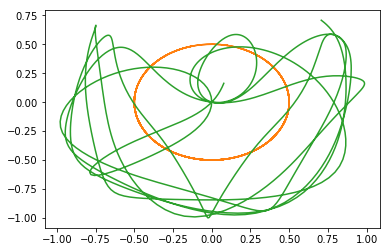

E aqui está a trajetória do pêndulo triplo em relação ao tempo:

In [14]:
p = integrate_pendulum(n=3, times=t)
x, y = get_xy_coords(p)
plt.plot(x, y);

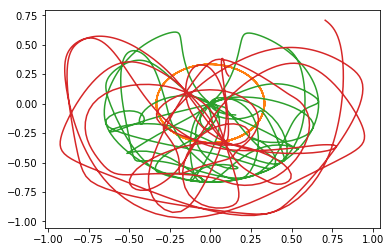

# Animação do Pêndulo

O uso de gráficos estáticos apenas mostra toda a trajetória que o pêndulo realiza durante um intervalo de tempo. Para tornar o estudo mais dinâmico, o desenvolvedor utilizou de um de seus últimos códigos de animação <Animation Tutorial> com o intuito de tornar mais fácil a compreensão o movimento do sistema dinâmico. Através da função de animação:

In [15]:
from matplotlib import animation


def animate_pendulum(n):
    t = np.linspace(0, 10, 200)
    p = integrate_pendulum(n, t)
    x, y = get_xy_coords(p)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.set(xlim=(-1, 1), ylim=(-1, 1))

    line, = ax.plot([], [], 'o-', lw=2)

    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        line.set_data(x[i], y[i])
        return line,

    anim = animation.FuncAnimation(fig, animate, frames=len(t),
                                   interval=1000 * t.max() / len(t),
                                   blit=True, init_func=init)
    plt.close(fig)
    return anim

In [16]:
anim = animate_pendulum(3)

Assim, podemos criar o movimento de um pêndulo triplo:

In [20]:
from IPython.display import HTML
# anim.save('triple-pendulum.mp4', extra_args=['-vcodec', 'libx264'])
HTML('<video controls loop src="http://jakevdp.github.io/videos/triple-pendulum.mp4" />')

# Movimento do Pêndulo Caótico

Finalmente, vamos ilustrar o resultado caótico de pequenas pertubações nas condições iniciais entre os pêndulos. O código a seguir anima qualquer número especificado de pêndulos quase idênticos, cada um com uma localização inicial pertubada ligeiramente: 

In [ ]:
from matplotlib import collections


#Especificando a quantidade de pêndulos a serem animados
def animate_pendulum_multiple(n, n_pendulums=41, perturbation=1E-6, track_length=15):
    oversample = 3
    track_length *= oversample
    
    t = np.linspace(0, 10, oversample * 200)
    p = [integrate_pendulum(n, t, initial_positions=135 + i * perturbation / n_pendulums)
         for i in range(n_pendulums)]
    positions = np.array([get_xy_coords(pi) for pi in p])
    positions = positions.transpose(0, 2, 3, 1)
    # A posição é uma matriz de 4 dimensões: (npendulums, len(t), n+1, xy)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.set(xlim=(-1, 1), ylim=(-1, 1))
    
    track_segments = np.zeros((n_pendulums, 0, 2))
    tracks = collections.LineCollection(track_segments, cmap='rainbow') #Função que faz a parte colorida da animação
    tracks.set_array(np.linspace(0, 1, n_pendulums))
    ax.add_collection(tracks)
    
    points, = plt.plot([], [], 'ok')
    
    pendulum_segments = np.zeros((n_pendulums, 0, 2))
    pendulums = collections.LineCollection(pendulum_segments, colors='black')
    ax.add_collection(pendulums)

    def init():
        pendulums.set_segments(np.zeros((n_pendulums, 0, 2)))
        tracks.set_segments(np.zeros((n_pendulums, 0, 2)))
        points.set_data([], [])
        return pendulums, tracks, points

    def animate(i):
        i = i * oversample
        pendulums.set_segments(positions[:, i])
        sl = slice(max(0, i - track_length), i)
        tracks.set_segments(positions[:, sl, -1])
        x, y = positions[:, i].reshape(-1, 2).T
        points.set_data(x, y)
        return pendulums, tracks, points

    interval = 1000 * oversample * t.max() / len(t)
    anim = animation.FuncAnimation(fig, animate, frames=len(t) // oversample,
                                   interval=interval,
                                   blit=True, init_func=init)
    plt.close(fig)
    return anim
    
anim = animate_pendulum_multiple(3)

In [22]:
# anim.save('triple-pendulum-chaos.mp4', extra_args=['-vcodec', 'libx264'])
HTML('<video controls loop src="http://jakevdp.github.io/videos/triple-pendulum-chaos.mp4" />')